In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from PIL import Image

# Assuming your data shape is (n_samples, 170, 5)
# where 170 = 17 Hz * 10 seconds, and 5 is the number of dimensions

def create_spectrograms(data, sample_rate=17):
    """
    Convert multi-dimensional time series to spectrograms
    
    Parameters:
    -----------
    data : array-like, shape (n_samples, time_steps, n_dimensions)
        Time series data
    sample_rate : int
        Sampling frequency in Hz
    
    Returns:
    --------
    spectrograms : array, shape (n_samples, freq_bins, time_bins, n_dimensions)
    """
    n_samples, time_steps, n_dims = data.shape
    spectrograms = []
    
    for sample in data:
        sample_spectrograms = []
        for dim in range(n_dims):
            # Compute Short-Time Fourier Transform (STFT)
            f, t, Sxx = signal.spectrogram(
                sample[:, dim], 
                fs=sample_rate,
                nperseg=32,  # Window length
                noverlap=16  # Overlap between windows
            )
            sample_spectrograms.append(Sxx)
        
        # Stack spectrograms for all dimensions
        spectrograms.append(np.stack(sample_spectrograms, axis=-1))
    
    return np.array(spectrograms), f, t
    

def visualize_spectrograms(spectrograms, frequencies, times, reseize=False):    
    fig, axes = plt.subplots(1, spectrograms.shape[3], figsize=(20, 4))
    for i in range(spectrograms.shape[3]):
        if reseize:
            img = Image.fromarray(spectrograms[0, :, :, i])
            img = img.resize((224, 224), Image.Resampling.BICUBIC)
            img = np.array(img)
        else:
            img = spectrograms[0, :, :, i]

        im = axes[i].pcolormesh(np.arange(img.shape[1]), np.arange(img.shape[0]), img, 
                                shading='gouraud', cmap='viridis')
        axes[i].set_ylabel('Frequency [Hz]')
        axes[i].set_xlabel('Time [sec]')
        axes[i].set_title(f'Dimension {i+1}')
        plt.colorbar(im, ax=axes[i])
    plt.tight_layout()
    plt.show()

Spectrogram shape: (100, 17, 9, 5)
Frequencies shape: (17,)
Time bins shape: (9,)


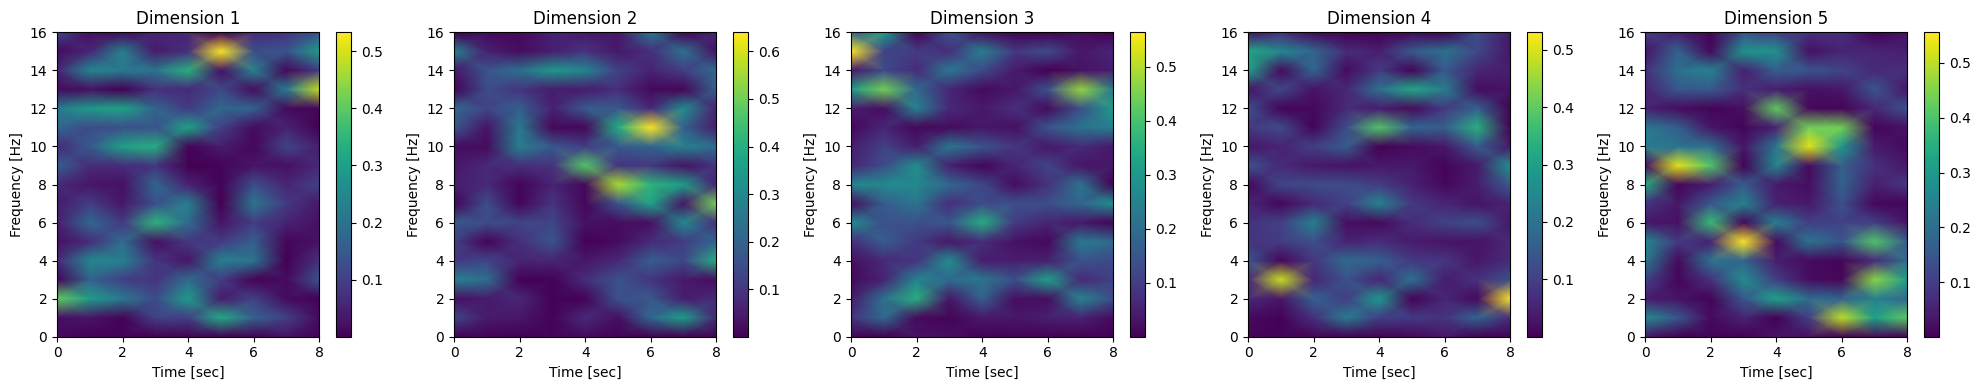

In [2]:

# Example usage:
# Generate dummy data: 100 samples, 170 time steps, 5 dimensions
dummy_data = np.random.randn(100, 170, 5)

# Create spectrograms
spectrograms, frequencies, times = create_spectrograms(dummy_data)
print(f"Spectrogram shape: {spectrograms.shape}")
print(f"Frequencies shape: {frequencies.shape}")
print(f"Time bins shape: {times.shape}")

# Visualize spectrograms for the first sample
visualize_spectrograms(spectrograms, frequencies, times)

In [3]:
print(frequencies)

[0.      0.53125 1.0625  1.59375 2.125   2.65625 3.1875  3.71875 4.25
 4.78125 5.3125  5.84375 6.375   6.90625 7.4375  7.96875 8.5    ]


In [4]:
import pandas as pd

df = pd.read_csv("../Multiple Distances Three Events.csv")
df.head()

,Dist1,Dist2,Dist3,Dist4,Dist5
0,0.000990,0.000747,0.000642,0.000693,0.000494
1,0.000986,0.000745,0.000636,0.000693,0.000500
2,0.000985,0.000742,0.000637,0.000692,0.000500
3,0.000981,0.000743,0.000640,0.000696,0.000499
4,0.000984,0.000747,0.000640,0.000686,0.000494


In [5]:
sample_data = df.iloc[:170].values * 1000

In [6]:
sample_data = sample_data.reshape(1, sample_data.shape[0], -1)

In [7]:
print(sample_data.shape)

(1, 170, 5)


Spectrogram shape: (1, 17, 9, 5)
Frequencies shape: (17,)
Time bins shape: (9,)


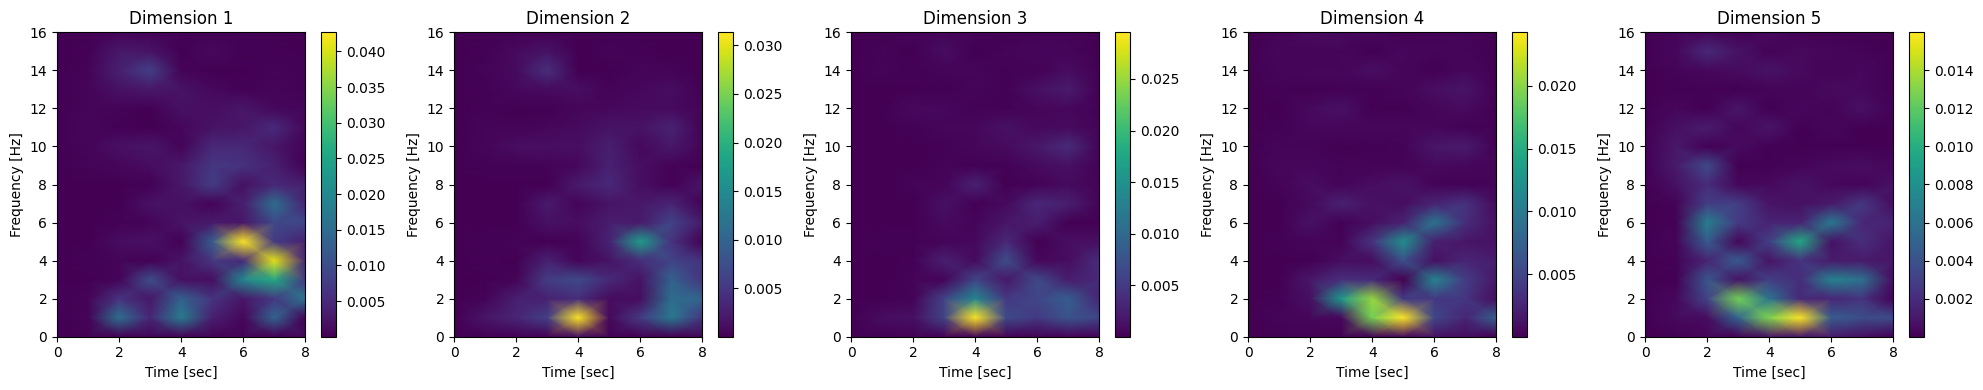

In [8]:
# Create spectrograms
spectrograms, frequencies, times = create_spectrograms(sample_data)
print(f"Spectrogram shape: {spectrograms.shape}")
print(f"Frequencies shape: {frequencies.shape}")
print(f"Time bins shape: {times.shape}")

# Visualize spectrograms for the first sample
visualize_spectrograms(spectrograms, frequencies, times)

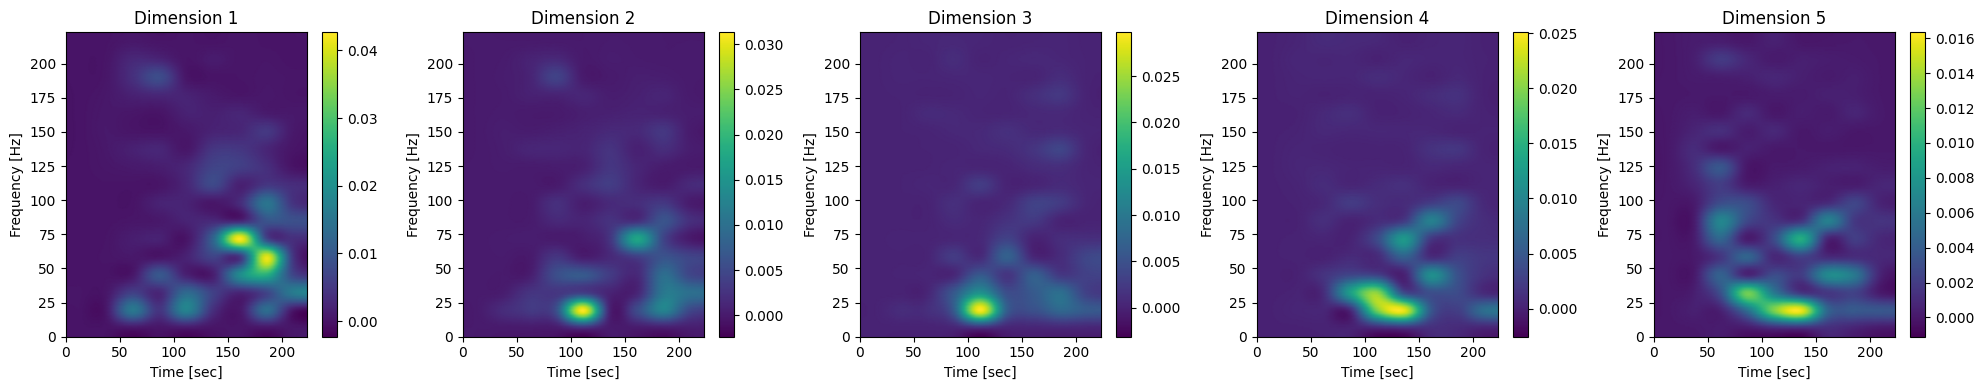

In [9]:
visualize_spectrograms(spectrograms, frequencies, times, reseize=True)

In [10]:
data = np.array(np.split(df.values, df.shape[0] // 170))
data.shape

(1011, 170, 5)

In [11]:
spectrograms, frequencies, times = create_spectrograms(data)
print(f"Spectrogram shape: {spectrograms.shape}")
print(f"Frequencies shape: {frequencies.shape}")
print(f"Time bins shape: {times.shape}")

Spectrogram shape: (1011, 17, 9, 5)
Frequencies shape: (17,)
Time bins shape: (9,)


In [12]:
resized_spectrograms = np.empty((spectrograms.shape[0], 224, 224, spectrograms.shape[3]))
for i in range(spectrograms.shape[0]):
    for j in range(spectrograms.shape[3]):
        img = Image.fromarray(spectrograms[i, :, :, j])
        img = img.resize((224, 224), Image.Resampling.BICUBIC)
        resized_spectrograms[i, :, :, j] = np.array(img)

In [13]:
resized_spectrograms.shape

(1011, 224, 224, 5)

In [14]:
labels = pd.read_csv("../Labels Three Events.csv").values.flatten()

In [22]:
X = spectrograms.reshape(spectrograms.shape[0], -1) 

In [23]:
X.shape

(1011, 765)

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42, stratify=labels)

In [25]:
y_train.shape

(808,)

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

model.fit(X_train, y_train.flatten())

,steps,"[('standardscaler', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [27]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.99      0.73       270
           1       0.82      0.31      0.45       269
           2       1.00      0.92      0.96       269

    accuracy                           0.74       808
   macro avg       0.80      0.74      0.71       808
weighted avg       0.80      0.74      0.71       808



In [28]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.99      0.70        67
           1       0.29      0.10      0.15        68
           2       0.88      0.74      0.80        68

    accuracy                           0.61       203
   macro avg       0.57      0.61      0.55       203
weighted avg       0.57      0.61      0.55       203



In [22]:
pd.read_csv("../Labels Three Events.csv").value_counts()

Labels
0         337
1         337
2         337
Name: count, dtype: int64